In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 25
matplotlib.rcParams["axes.labelsize"] = 25
from matplotlib import pyplot as plt
#%matplotlib tk
from scipy.optimize import minimize
import scipy.linalg
import bisect

import pulse
import modulated_tls
import single_photon_emission
import two_photon_emission

In [2]:
class GaussianPulse(pulse.Pulse):
    def __init__(self, pulse_amp, t_mean, t_stddev):
        self._t_mean = t_mean
        self._t_stddev = t_stddev
        self._pulse_amp = pulse_amp

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        return self._pulse_amp * np.exp(
            -(t - self._t_mean)**2 / self._t_stddev**2)
    
    
class RectangularPulse(pulse.Pulse):
    def __init__(self, pulse_amp, pulse_len):
        self._pulse_amp = pulse_amp
        self._pulse_len = pulse_len

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        if t < self._pulse_len:
            return self._pulse_amp
        else:
            return 0
        
def compute_fourier_transform(phi, times, freqs):
    df = freqs[1] - freqs[0]
    fft_matrix = np.exp(
        -1.0j * freqs[:, np.newaxis] @ times[np.newaxis, :])/ np.sqrt(2 * np.pi) * df
    return fft_matrix @ phi
    

In [20]:
# Reproducing transmission spectrum.
gamma = 98 * 1e-3
inp_freqs = np.linspace(-10, 10, 1000)


# freq_2f = 1.500
# amps = [2.910, 2.250]
# phases = [0, 0]
# harmonics = [1, 3]


# freq_2f = 1.200*2
# amps = np.array([2.360, 2.110, 2.220, 2.020, 2.250])*2
# phases = [np.pi / 6, -np.pi / 6, np.pi / 2, -5 * np.pi / 6, 5 * np.pi / 6]
# harmonics = [1, 2, 3, 4, 5]


freq_2f = np.pi*2*1/np.sqrt(gamma) / (2*0.1 / gamma)
print(freq_2f)
amps = [0, 0, 0]
phases = [np.pi/2, 0, np.pi/2]
harmonics = [1, 3, 0.01]

delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

# pulsetimes = [-1000, 0.5/gamma, 1/gamma]#0.0761 / gamma] #0.075 / gamma]

# pulseamps = [0, 15, -200]

# delta_2f = pulse.ArbPulseConst(pulsetimes, pulseamps)

tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta_2f)

pulse_width = 1 / gamma
pulse_area = np.pi/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

# pulse_amp = 0.5* pulse_area / (np.sqrt(np.pi) * pulse_width) * 1/np.sqrt(gamma)
# laser_pulse = GaussianPulse(pulse_amp, pulse_width, 5*pulse_width)

pulse_amp = pulse_area / (2 * pulse_width)
laser_pulse = RectangularPulse(pulse_amp, pulse_width)

times = np.linspace(0, 10 / gamma, 2000)
output_2f = two_photon_emission.two_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)

output_2fsingle = single_photon_emission.compute_single_photon_state(
        tls_obj_2f, times, laser_pulse, 1)

output_2fzero = two_photon_emission.zero_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)

print(abs(output_2fzero)**2)
print(np.sum(np.abs(output_2fsingle)**2)*(times[-1] / len(times)))
print(0.5*np.sum(np.sum(np.abs(output_2f)**2))*(times[-1] / len(times))**2)
print(1-(abs(output_2fzero)**2+np.sum(np.abs(output_2fsingle)**2)*(times[-1] / len(times))+0.5*np.sum(np.sum(np.abs(output_2f)**2))*(times[-1] / len(times))**2))

print("P2/P1")
print(0.5*(np.sum(np.sum(np.abs(output_2f)**2))*(times[-1] / len(times))**2)/(np.sum(np.abs(output_2fsingle)**2)*(times[-1] / len(times))))

9.834740623457016
0.019739550327491
0.8870916841412423
0.09107588322315659
0.002092882308110111
P2/P1
0.10266794836581461


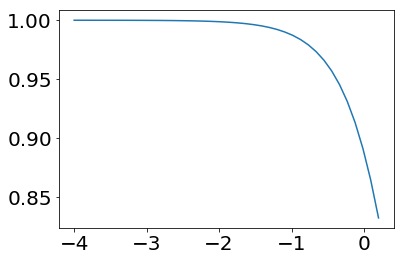

In [67]:
widths = np.logspace(-4, 0.2, 40)
P1s = []

for width in widths:
    
    freq_2f = 10
    amps = [16*0]
    phases = [np.pi/2]
    harmonics = [1]

    delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

    pulse_width = width / gamma
    pulse_area = np.pi/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = pulse_area / (2 * pulse_width)
    laser_pulse = RectangularPulse(pulse_amp, pulse_width)

    times = np.append(np.linspace(0, pulse_width*1.3, 100)[:-1], np.linspace(pulse_width*1.3, 10 / gamma, 2000))

    output_2fsingle = single_photon_emission.compute_single_photon_state(
            tls_obj_2f, times, laser_pulse, 1)
    
    P1s.append(np.trapz(np.abs(output_2fsingle)**2, times))
    
plt.plot(np.log10(widths), P1s)
plt.show()

In [38]:
P1s

[0.99993411377936,
 0.9999258173657202,
 0.9999120155965727,
 0.9998890555046953,
 0.9998508607830834,
 0.9997873250744399,
 0.9996816415907716,
 0.9995058677286227,
 0.999213565933355,
 0.998727615212856,
 0.9979200841358312,
 0.9965791609445954,
 0.9943552769859124,
 0.9906746016814114,
 0.9846036531023822,
 0.9746470608147089,
 0.9584720628750771,
 0.9326063522574508,
 0.8923109923101873,
 0.8321621678498171]

0.0001
[1.00202683 1.56570683]
-0.9999442083087596
0.00016636142493842227
[1.00202845 1.56233267]
-0.9999359285035067
0.0002767612370754228
[1.00203127 1.55670208]
-0.9999221543941051
0.0004604239376758779
[1.00203589 1.54735108]
-0.999899240399262
0.0007659678234751839
[1.00204378 1.53179241]
-0.9998611225895987
0.0012742749857031347
[1.00205732 1.50591556]
-0.9997977154239095
0.0021199020238496097
[1.00208305 1.46285993]
-0.9996922470447078
0.0035266992141746592
[1.00215214 1.39122289]
-0.9995168297278116
0.0058670670659931035
[1.00246718 1.27206377]
-0.9992250569443851
0.00976053637307901
[1.00447848 1.07381765]
-0.9987390520769583
0.016237767391887224
[1.01854351 0.74400958]
-0.9979195752174194
0.027013381211330047
[1.11687351 0.19535064]
-0.99641045548845
0.044939845907216704
[1.83604633 2.42417261]
-0.9392487276997016
0.07476256801637694
[1.63468805 2.47646531]
-0.5829322965404076
0.12437607347260171
[3.15567986 1.52107234]
-0.9737286755069043
0.20691380811147903
[2.19659092 2.03

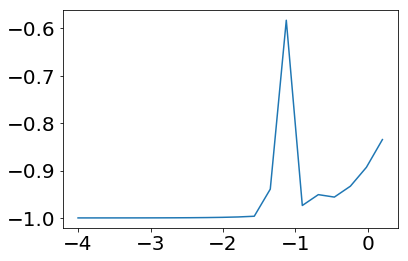

In [34]:
widths = np.logspace(-4, 0.2, 40)
P1sOpt = []

def calcP1(args, width):
    freq_2f = 10
    amps = [16]
    phases = [args[1]]
    harmonics = [1]

    delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

    pulse_width = width / gamma
    pulse_area = args[0] * np.pi/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = pulse_area / (2 * pulse_width)
    laser_pulse = RectangularPulse(pulse_amp, pulse_width)

    times = np.append(np.linspace(0, pulse_width*1.3, 100)[:-1], np.linspace(pulse_width*1.3, 10 / gamma, 2000))

    output_2fsingle = single_photon_emission.compute_single_photon_state(
            tls_obj_2f, times, laser_pulse, 1)
    
    return - np.trapz(np.abs(output_2fsingle)**2, times) 
    

for width in widths:
    
    print(width)
    
    x0 = [1, np.pi/2]
    res = minimize(calcP1, x0, method='Nelder-Mead', tol=1e-5, args = width)
    print(res.x)
    print(res.fun)
    P1sOpt.append(res.fun)
    
plt.plot(np.log10(widths), P1sOpt)
plt.show()

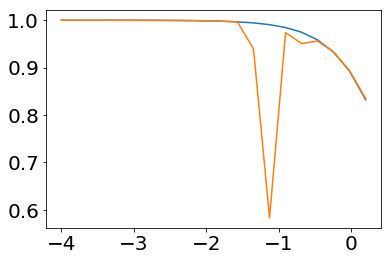

In [39]:

plt.plot(np.log10(widths), np.array(P1s))
plt.plot(np.log10(widths), - np.array(P1sOpt))

plt.show()

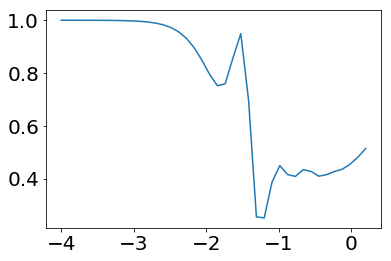

In [68]:
widths = np.logspace(-4, 0.2, 40)
P1sRand = []

for width in widths:
    
    freq_2f = 10
    amps = [16]
    phases = [np.pi*2]
    harmonics = [1]

    delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

    pulse_width = width / gamma
    pulse_area = np.pi/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = pulse_area / (2 * pulse_width)
    laser_pulse = RectangularPulse(pulse_amp, pulse_width)

    times = np.append(np.linspace(0, pulse_width*1.3, 100)[:-1], np.linspace(pulse_width*1.3, 10 / gamma, 2000))

    output_2fsingle = single_photon_emission.compute_single_photon_state(
            tls_obj_2f, times, laser_pulse, 1)
    
    P1sRand.append(np.trapz(np.abs(output_2fsingle)**2, times))
    
plt.plot(np.log10(widths), P1sRand)
plt.show()

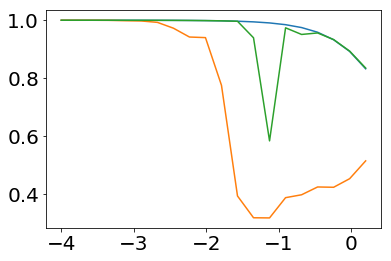

In [43]:
plt.plot(np.log10(widths), np.array(P1s))
plt.plot(np.log10(widths), np.array(P1sRand))
plt.plot(np.log10(widths), - np.array(P1sOpt))

plt.show()

In [60]:
# 0.027013381211330047
# [1.11687351 0.19535064]
# -0.99641045548845
# 0.044939845907216704
# [1.83604633 2.42417261]
# -0.9392487276997016
# 0.07476256801637694
# [1.63468805 2.47646531]
# -0.5829322965404076
# 0.12437607347260171
# [3.15567986 1.52107234]
# -0.9737286755069043
# 0.20691380811147903
# [2.19659092 2.03084482]
# -0.9508282585384048
# 0.34422475956860926
# [2.25743874 1.32278886]
# -0.9560058120287145


width =  0.20691380811147903

x0 = [3, 0]
res = minimize(calcP1, x0, method='Nelder-Mead', tol=1e-5, args = width)
print(res.x)
print(res.fun)


[2.51025281 0.46004136]
-0.9705082532615569


In [61]:
#P1sOptBetter = P1sOpt
P1sOptBetter[15] = res.fun

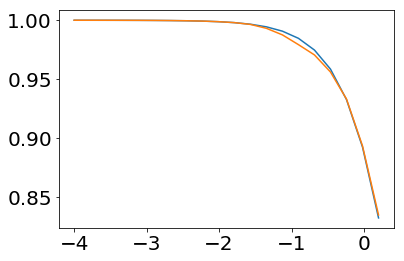

In [64]:
plt.plot(np.log10(widths), np.array(P1s))
#plt.plot(np.log10(widths), np.array(P1sRand))
plt.plot(np.log10(widths), - np.array(P1sOptBetter))

plt.show()

0.0001
[1.00202683 1.56570683]
-0.9999442083087596
0.0001281422388944084
[1.00202755 1.56426935]
-0.9999406970320109
0.00016420433388871633
[1.00202838 1.5624361 ]
-0.9999361976380803
0.0002104151098066509
[1.00202956 1.56008222]
-0.9999304320710226
0.0002696306326783704
[1.00203109 1.55706849]
-0.9999230440378988
0.0003455107294592218
[1.00203308 1.55320751]
-0.999913577000563
0.00044274518434944915
[1.00203556 1.54825254]
-0.9999014459793154
0.00056734359182256
[1.00203875 1.54190722]
-0.9998859014312111
0.0007270067807853822
[1.00204267 1.53377694]
-0.9998659829786117
0.0009316027658125524
[1.00204802 1.52336016]
-0.9998404601407077
0.001193776641714437
[1.00205532 1.51001286]
-0.9998077564243647
0.0015297321160913596
[1.00206406 1.49290585]
-0.9997658521106679
0.001960232982646277
[1.00207736 1.47098533]
-0.9997121597506383
0.002511886431509582
[1.00209829 1.44289622]
-0.9996433646537813
0.003218787511821236
[1.00213261 1.40690044]
-0.9995552202509616
0.004124626382901352
[1.002201

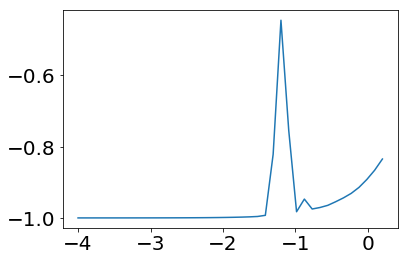

In [66]:
widths = np.logspace(-4, 0.2, 40)
P1sOptFine = []
P1sOptFineX = []

for width in widths:
    
    print(width)
    
    x0 = [1, np.pi/2]
    res = minimize(calcP1, x0, method='Nelder-Mead', tol=1e-5, args = width)
    print(res.x)
    print(res.fun)
    P1sOptFine.append(res.fun)
    P1sOptFineX.append(res.x)
    
plt.plot(np.log10(widths), P1sOptFine)
plt.show()

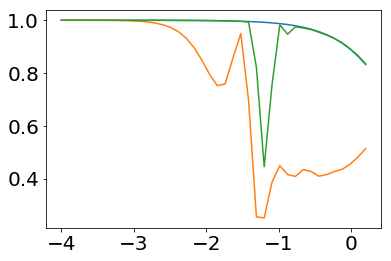

In [69]:
plt.plot(np.log10(widths), np.array(P1s))
plt.plot(np.log10(widths), np.array(P1sRand))
plt.plot(np.log10(widths), - np.array(P1sOptFine))

plt.show()

In [71]:
fix = []
fixX = []

for ii in range(22,35):
    print(widths[ii])
    
    x0 = [3.5, 0]
    res = minimize(calcP1, x0, method='Nelder-Mead', tol=1e-5, args = widths[ii])
    print(res.x)
    print(res.fun)
    fix.append(res.fun)
    fixX.append(res.x)

0.023400803470013467
[2.91408098 0.37929007]
-0.9964556443830429
0.02998631348575567
[2.76206772 0.04398395]
-0.9947925587913955
0.03842513346254323
[ 2.28322324 -0.38571074]
-0.9926856842190985
0.04923882631706741
[ 4.55635116 -0.93631584]
-0.9924339267005978
0.06309573444801936
[4.35244993 1.49972227]
-0.9900055812363461
0.08085228676856251
[4.11672155 0.59560313]
-0.9869202479217791
0.10360593046256342
[ 2.38993431 -0.56296043]
-0.9825955470008046
0.13276295892211268
[3.12410713 1.09403394]
-0.947108663027765
0.17012542798525893
[ 2.21060517 -0.80837606]
-0.974925691178456
0.2180025323490052
[2.35500035 1.4663792 ]
-0.9707316252775122
0.27935332579852223
[2.2776146  1.48419684]
-0.9646479773278344
0.35796960610421735
[ 2.15280116 -0.94822059]
-0.9546529175635952
0.458710267823439
[2.20183002 0.2056141 ]
-0.9440544493926973


In [82]:
bestFine = P1sOptFine
bestFine[22:35] = fix

bestFineX = P1sOptFineX
bestFineX[22:35] = fixX

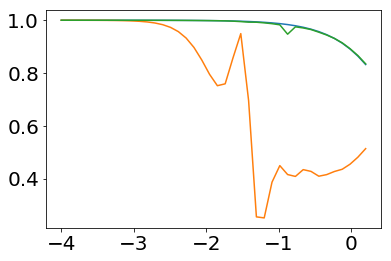

In [74]:
plt.plot(np.log10(widths), np.array(P1s))
plt.plot(np.log10(widths), np.array(P1sRand))
plt.plot(np.log10(widths), - np.array(bestFine))

plt.show()

In [88]:
# 0.13276295892211268
# [3.12410713 1.09403394]
# -0.947108663027765


width = 0.13276295892211268

x0 = [5, 2]
res = minimize(calcP1, x0, method='Nelder-Mead', tol=1e-5, args = width)
print(res.x)
print(res.fun)

[3.12410376 1.09403588]
-0.9471086630245419


In [83]:
bestFine[29] = -0.9770766011522979
bestFineX[29] = [7.3457529,  1.09402549]

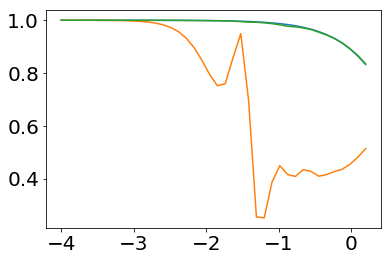

In [84]:
plt.plot(np.log10(widths), np.array(P1s))
plt.plot(np.log10(widths), np.array(P1sRand))
plt.plot(np.log10(widths), - np.array(bestFine))

plt.show()

In [91]:
def calcG20(args, width, amp):
    freq_2f = 10
    amps = [amp*16]
    phases = [args[1]]
    harmonics = [1]

    delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

    pulse_width = width / gamma
    pulse_area = args[0] * np.pi/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = pulse_area / (2 * pulse_width)
    laser_pulse = RectangularPulse(pulse_amp, pulse_width)

    times = np.append(np.linspace(0, pulse_width*1.3, 100)[:-1], np.linspace(pulse_width*1.3, 10 / gamma, 2000))

    output_2fsingle = single_photon_emission.compute_single_photon_state(
            tls_obj_2f, times, laser_pulse, 1)
    
    output_2fzero = two_photon_emission.zero_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)
    
    P1 = np.trapz(np.abs(output_2fsingle)**2, times) 
    P0 = abs(output_2fzero)**2
    
    P2 = 1 - P0 - P1
    
    return 2*P2/(P1+2*P2)**2

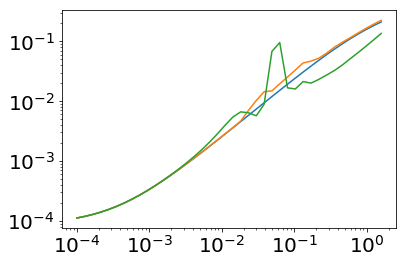

In [92]:
g20_unmod = []
g20_mod = []
g20_bad = []
for ii in range(len(widths)):
    g20_unmod.append(calcG20([1,0], widths[ii], 0))
    g20_mod.append(calcG20(bestFineX[ii], widths[ii], 1))
    g20_bad.append(calcG20([1,0], widths[ii], 1))

plt.loglog(widths, g20_unmod)
plt.loglog(widths, g20_mod)
plt.loglog(widths, g20_bad)
plt.show()

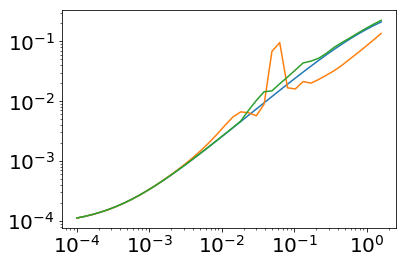

In [93]:
plt.loglog(widths, g20_unmod)
plt.loglog(widths, g20_bad)
plt.loglog(widths, g20_mod)

plt.show()

In [22]:
widths = np.logspace(-4, 0.2, 10)
P1sGauss = []

gamma = 0.181

for width in widths:
    
    freq_2f = 10
    amps = [16*0]
    phases = [np.pi/2]
    harmonics = [1]

    delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

    pulse_width = width / gamma
    pulse_area = np.pi/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = 0.5* pulse_area / (np.sqrt(np.pi) * pulse_width) #* 1/np.sqrt(gamma)
    laser_pulse = GaussianPulse(pulse_amp, 5*pulse_width, pulse_width)
    
    times = np.append(np.linspace(0, pulse_width*8, 100)[:-1], np.linspace(pulse_width*8, 10 / gamma, 2000))

    #times = np.linspace(0, 10 / gamma, 2000)
    
    output_2fsingle = single_photon_emission.compute_single_photon_state(
            tls_obj_2f, times, laser_pulse, 1)
    
    pulseVals = []
    for t in times:
        pulseVals.append(laser_pulse(t))
    print(np.trapz(pulseVals, times)/pulse_area)
    
    plt.plot(times, np.abs(output_2fsingle)**2)
    plt.show()
    
    P1sGauss.append(np.trapz(np.abs(output_2fsingle)**2, times))
    
plt.plot(np.log10(widths), P1sGauss)
plt.show()

0.500865061377662
0.5002916220531468
0.5000958183931732
0.5000289602853271
0.5000063904236082
0.5000007701209754
0.499999985077148
0.4999998959669092
0.49999988718340105
0.48399401634946276


In [5]:
oldOpt = np.load('opt_params_All.npy')
print((oldOpt))

widthsTest = np.logspace(-3, 1, 59)
gamma = 0.181



[[-8.96453871e-01  3.26638519e+00]
 [-9.34715476e-01  3.24799143e+00]
 [-9.79720013e-01  3.23230272e+00]
 [-1.03261110e+00  3.21894236e+00]
 [-1.09475270e+00  3.20764684e+00]
 [-1.16782354e+00  3.19812930e+00]
 [-1.25389961e+00  3.19028285e+00]
 [-1.35511070e+00  3.18401595e+00]
 [-1.47435385e+00  3.17954343e+00]
 [-3.36410479e+00  3.17719583e+00]
 [-1.78092808e+00  3.17813290e+00]
 [-3.68889649e+00  3.18337928e+00]
 [-2.20814040e+00  3.19672828e+00]
 [ 2.15564479e+00  3.22024709e+00]
 [ 1.88091792e+00  3.26131726e+00]
 [ 3.10375127e+00  3.32722517e+00]
 [ 2.66129113e+00  3.41950975e+00]
 [ 7.45030644e-01  3.53990202e+00]
 [ 2.48274704e-01  3.68111387e+00]
 [-2.60571458e-01  3.81905115e+00]
 [-5.54749703e-01  4.00465614e+00]
 [-1.46013323e+00  4.42610741e+00]
 [-2.52892459e+00  4.85709451e+00]
 [ 2.51939810e+00  5.19347385e+00]
 [ 1.04471957e+00  5.38115712e+00]
 [-6.51661013e-01  5.44570865e+00]
 [-2.68817439e+00  5.45641603e+00]
 [ 1.22519991e+00  5.45943158e+00]
 [-1.41929612e+00  5

In [6]:
def calcP1Gauss(args, width):
    gamma = 0.181
    
    freq_2f = 10*2*np.pi
    amps = [16, -10]
    phases = [args[0]-np.pi/2, 0]
    harmonics = [1, 0]

    delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

   
    pulse_width = width * np.sqrt(2)
    pulse_area = args[1]/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = 0.5* pulse_area / (np.sqrt(np.pi) * pulse_width) #* 1/np.sqrt(gamma)
    laser_pulse = GaussianPulse(pulse_amp, 3.5*pulse_width, pulse_width)
    
    times = np.append(np.linspace(0, pulse_width*8, 100)[:-1], np.linspace(pulse_width*8, 10 / gamma, 2000))

    #times = np.linspace(0, 10 / gamma, 2000)
    
    output_2fsingle = single_photon_emission.compute_single_photon_state(
            tls_obj_2f, times, laser_pulse, 1)
    
    pulseVals = []
    for t in times:
        pulseVals.append(laser_pulse(t))
    print(np.trapz(pulseVals, times)/pulse_area)
    
    plt.plot(times, np.abs(output_2fsingle)**2)
    plt.show()
    print(np.abs(output_2fsingle[bisect.bisect_left(times, 10)])**2/np.max(np.abs(output_2fsingle)**2))
    
    return - np.trapz(np.abs(output_2fsingle)**2, times) 

0.4999998094640022


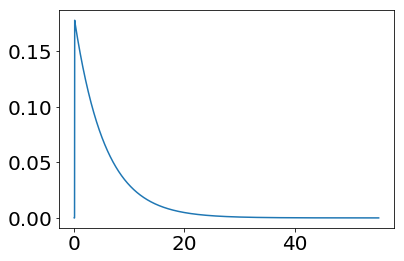

0.1646945777342763
0.4999998094039909


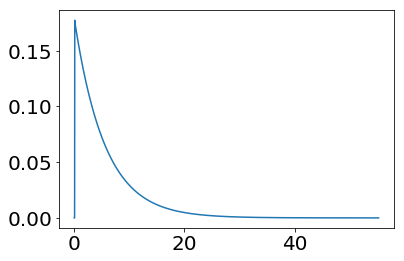

0.16464535944349876
0.4999998093527919


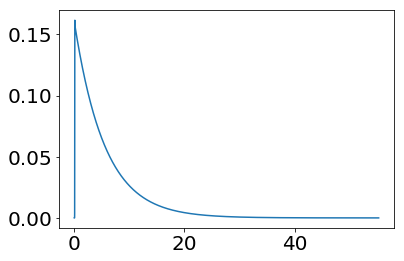

0.16240309547961748
0.4999998093091153


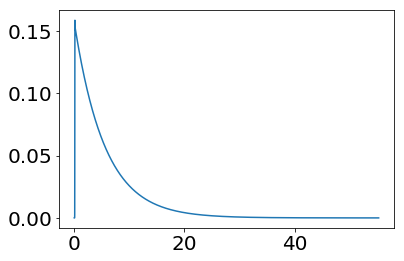

0.16186999613748132
0.4999998092718738


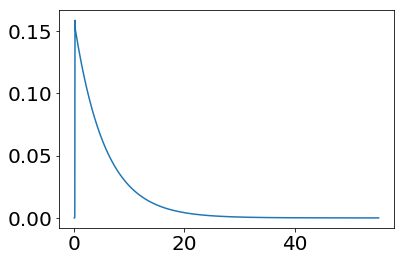

0.16137262977855563
0.49999980924017245


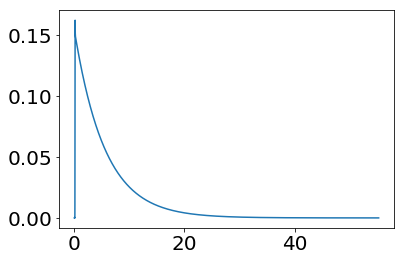

0.15575045752738653
0.4999998092133004


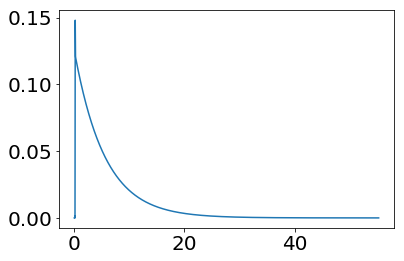

0.13824805334781345
0.49999980919070774


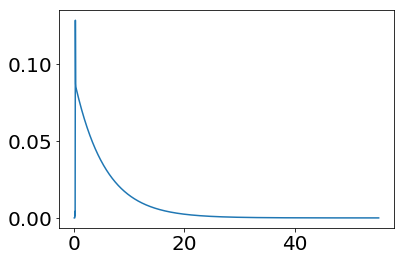

0.11384224384963265
0.4999998091719537


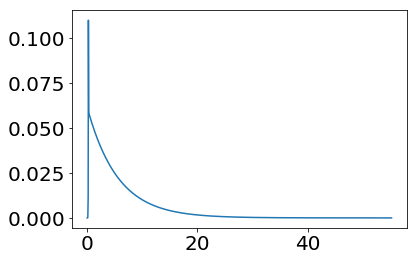

0.09150271582025413
0.4999998091566417


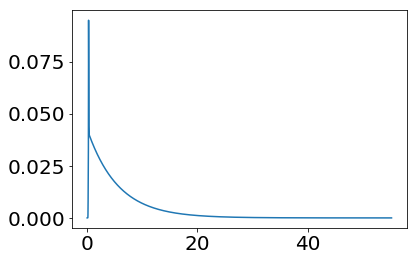

0.07333639220401215
0.4999998091443693


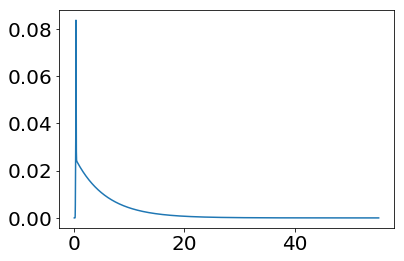

0.05086586799112138
0.4999998091347135


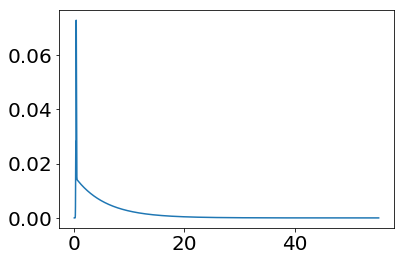

0.034581503983418665
0.4999998091272441


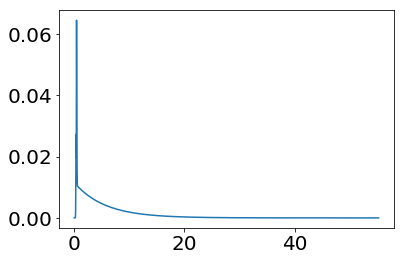

0.029048261054113227
0.49999980912154995


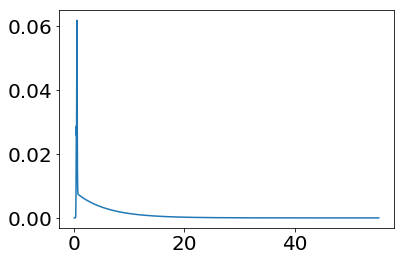

0.02205623220676961
0.4999998091172616


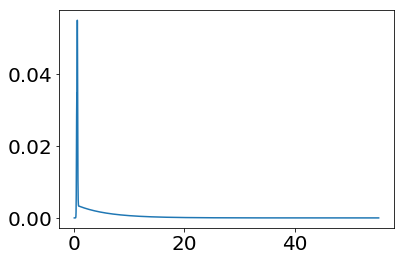

0.011386901379385115


In [8]:
oldP1 = []
for jj in range(15,30):
    oldP1.append(calcP1Gauss(oldOpt[jj], widthsTest[jj]))
    
#plt.plot(np.log10(widthsTest[15:30]), - np.array(oldP1))
#plt.show()

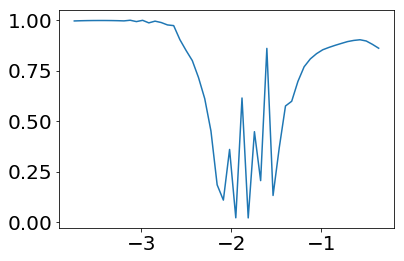

In [140]:
    
plt.plot(np.log10(widthsTest[0:50]*gamma), - np.array(oldP1[0:50]))
plt.show()

In [204]:
oldPar = []
oldParX = []
for ii in range(15,30):
    print(widthsTest[ii])
    
    x0 = [0, np.pi]
    res = minimize(calcP1Gauss, x0, method='Nelder-Mead', tol=1e-5, args = widthsTest[ii])
    print(res.x)
    print(res.fun)
    oldPar.append(res.fun)
    oldParX.append(res.x)

0.010826367338740546
[-0.53587509  3.14263933]
-0.9992432752298307
0.01268961003167922
[-0.62810699  3.14305366]
-0.9991206137988891
0.01487352107293511
[-0.73619954  3.14373675]
-0.9989768916078325
0.017433288221999882
[-0.86290486  3.14491545]
-0.9988085080912136
0.020433597178569417
[-1.01141399  3.14698664]
-0.9986112566551546
0.02395026619987486
[-1.18547684  3.15067429]
-0.9983802272377738
0.02807216203941177
[-1.38950323  3.15729516]
-0.9981096899712986
0.03290344562312668
[0.02467188 3.08268779]
-0.751954918998319
0.03856620421163472
[1.23266327 3.19007839]
-0.997422033055277
0.04520353656360243
[0.90413112 3.22661106]
-0.9969872474442144
0.05298316906283707
[0.51905812 3.28910315]
-0.9964757744545442
0.06210169418915616
[0.06771081 3.39372237]
-0.995868497729531
0.0727895384398315
[-0.46131196  3.56588725]
-0.9951317097319542
0.08531678524172806
[-1.0813792   3.84857382]
-0.9941937173826498
0.1
[1.33316322 9.1939262 ]
-0.9881978767914922
